<a href="https://colab.research.google.com/github/doopees/nsga-ii/blob/main/notebook/nsga_ii.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import matplotlib.pyplot as plt

In [2]:
class Item:
    num_instances = 0

    def __init__(self, value, weight):
        self.value = value
        self.weight = weight
        self.id = Item.num_instances
        self.name = f'i{self.id}'
        Item.num_instances += 1

    def __repr__(self):
        return self.name

In [3]:
class Individual:

    def __init__(self):
        self.rank = None
        self.distance = None
        self.dominated = None
        self.dominated_by = None

    def dominates(self, other):
        # The aim is to minimize f
        return (all(f(self) <= f(other) for f in self.functions)
                and any(f(self) < f(other) for f in self.functions))

    def __lt__(self, other):
        return (self.rank < other.rank
                or (self.rank == other.rank
                    and self.distance > other.distance))

In [4]:
class KnapsackIndividual(Individual):
    num_instances = 0

    def __init__(self, chromosome, items, max_weight=600):
        self.chromosome = chromosome
        self.items = {item: gen for item, gen in zip(items, chromosome)}
        self.max_weight = max_weight
        self.name = f'p{KnapsackIndividual.num_instances}'
        KnapsackIndividual.num_instances += 1

    def __repr__(self):
        return self.name

    def __len__(self):
        return len(self.chromosome)

    def array(self):
        return [item if gen else ''
                for item, gen in self.items.items()]
    
    def total_value(self):
        return sum(gen and item.value
                   for item, gen in self.items.items())

    def total_weight(self):
        return sum(gen and item.weight
                   for item, gen in self.items.items())
        
    def minus_total_value(self):
        return -self.total_value()

    def actual_total_weight(self):
        total = self.total_weight()
        return total if total <= self.max_weight else float('inf')
        
    @property
    def functions(self):
        return (KnapsackIndividual.minus_total_value,
                KnapsackIndividual.total_weight)
        
    def crossover_onepoint(self, other):
        idx = random.randrange(1 + len(self))
        child1 = KnapsackIndividual(
            self.chromosome[:idx] + other.chromosome[idx:],
            self.items)
        child2 = KnapsackIndividual(
            other.chromosome[:idx] + self.chromosome[idx:],
            self.items)
        return child1, child2

    def mutation_flip(self):
        idx = random.randrange(len(self))
        chromosome = self.chromosome.copy()
        chromosome[idx] = int(not chromosome[idx])
        return KnapsackIndividual(chromosome, self.items)

In [5]:
def non_dominated_sort(population):
    rank = 0
    frontier = []
    frontiers = []
    for individual in population:
        individual.dominated_by = 0
        individual.dominated = set()
        for other in population:
            if individual.dominates(other):
                individual.dominated.add(other)
            elif other.dominates(individual):
                individual.dominated_by += 1
        if not individual.dominated_by:
            individual.rank = rank
            frontier.append(individual)
    while frontier:
        frontiers.append(frontier)
        next_frontier = []
        for individual in frontier:
            for dominated in individual.dominated:
                dominated.dominated_by -= 1
                if not dominated.dominated_by:
                    dominated.rank = rank + 1
                    next_frontier.append(dominated)
        rank += 1
        frontier = next_frontier
    return frontiers

In [6]:
def batches(iterable, n=3):
        for i in range(len(iterable) - (n-1)):
            yield iterable[i:i+n]

def crowding_distance_assignment(frontier):
    functions = frontier[0].functions
    for individual in frontier:
        individual.distance = 0
    for f in functions:
        # Reverse is not used because the aim is to minimize f
        frontier = sorted(frontier, key=f)
        frontier[0].distance = frontier[-1].distance = float('inf')
        for prev, individual, next_ in batches(frontier):
            individual.distance += f(next_) - f(prev)

In [7]:
def next_population(parents, offspring):
    new_population = []
    popsize = len(parents)
    frontiers = non_dominated_sort(parents + offspring)
    for frontier in frontiers:
        crowding_distance_assignment(frontier)
        if len(new_population) + len(frontier) > popsize:
            break
        new_population.extend(frontier)
    needed = popsize - len(new_population)
    frontier = sorted(frontier)
    new_population.extend(frontier[:needed])
    return new_population

In [8]:
random.seed(7)

Item.num_instances = 0
KnapsackIndividual.num_instances = 0

popsize = 60
num_items = 60

items = [Item(random.uniform(0, 60),
              random.uniform(0, 60)) for _ in range(num_items)]

population = [KnapsackIndividual(
                  [random.getrandbits(1) for _ in range(num_items)],
                  items
              ) for _ in range (popsize)]

In [9]:
frontiers = non_dominated_sort(population)
frontiers

[[p0, p3, p11, p15, p16, p25, p26, p31, p34, p36, p37, p50, p51],
 [p5, p45, p46, p23, p19, p8, p59, p35, p13, p22, p44, p41],
 [p56, p57, p14, p29, p17, p47, p9, p58, p52],
 [p21, p55, p39, p1, p7, p33, p30],
 [p20, p28, p24, p6, p49, p54, p48, p43, p27, p4],
 [p12, p42, p10, p38, p2],
 [p53, p32, p18, p40]]

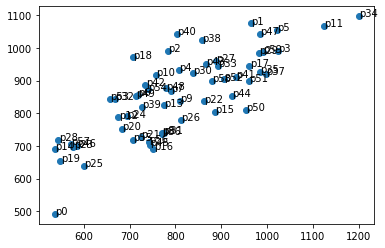

In [10]:
def plot(population, color='C0', show_names=False):
    for p in population:
        x = p.total_value()
        y = p.total_weight()
        plt.plot(x, y, marker='o', color=color)
        if show_names:
            plt.text(x+0.5, y-1, p)

plot(population, show_names=True)

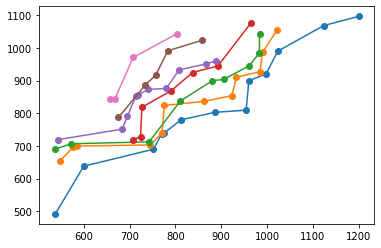

In [11]:
def plot_frontiers(frontiers):
    for i, frontier in enumerate(frontiers):
        color = f'C{i}'
        plot(frontier, color)
        frontier = sorted(frontier, key=lambda p: p.total_value())
        for p1, p2 in batches(frontier, n=2):
            x1 = p1.total_value()
            y1 = p1.total_weight()
            x2 = p2.total_value()
            y2 = p2.total_weight()
            plt.plot([x1, x2], [y1, y2], color)

plot_frontiers(frontiers)

In [12]:
parents = population[:popsize//2]
offspring = population[-popsize//2:]

new_population = next_population(parents, offspring)

In [13]:
def selection(population):
    mating_pool = []
    for _ in range(len(population)):
        match1 = random.sample(population, 2)
        match2 = random.sample(population, 2)
        parents = min(match1), min(match2)
        mating_pool.append(parents)
    return mating_pool


def crossover(mating_pool):
    offspring = []
    for parent1, parent2 in mating_pool:
        children = parent1.crossover_onepoint(parent2)
        offspring.extend(children)
    return offspring


def mutation(offspring, pmut):
    return [child.mutation_flip()
            if random.random() < pmut else child
            for child in offspring]


def nsga_ii(population, ngen, pmut):
    frontiers = non_dominated_sort(population)
    for frontier in frontiers:
        crowding_distance_assignment(frontier)
    
    for i in range(ngen):
        mating_pool = selection(population)
        offspring = crossover(mating_pool)
        offspring = mutation(offspring, pmut)
        population = next_population(population, offspring)

    return population

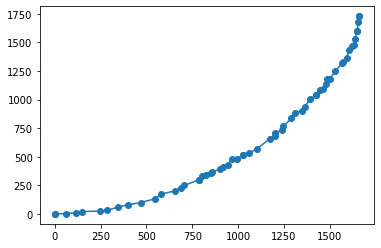

In [14]:
pareto = nsga_ii(population, 300, 0.5)
frontiers = non_dominated_sort(pareto)

plot_frontiers(frontiers)